In [1]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
from pprint import pprint
import pandas as pd
from tqdm import trange

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [23]:
comments = c_df

comments = comments.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments.head()

,body,processed_text
0,Worrying part of the U.K. known cases are all ...,worrying part of the uk known cases are all pe...
1,Surely it’s going to hit at all large multi-na...,surely it’s going to hit at all large multi-na...
2,I’m not sure Bath is considered large! It is i...,i’m not sure bath is considered large it is in...
3,"Try screwfix and shops like that, paint suppli...",try screwfix and shops like that paint supplie...
4,Adding to above wickes is a good shout or most...,adding to above wickes is a good shout or most...


In [25]:
# REMOVE EMAILS AND NEWLINE CHARACTERS

data = comments['processed_text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['worrying part of the uk known cases are all people would of been in a big '
 'contact circle:']


In [ ]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [26]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
        
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['worrying', 'part', 'of', 'the', 'uk', 'known', 'cases', 'are', 'all', 'people', 'would', 'of', 'been', 'in', 'big', 'contact', 'circle']


In [27]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['worrying', 'part', 'of', 'the', 'uk', 'known', 'cases', 'are', 'all', 'people', 'would', 'of', 'been', 'in', 'big', 'contact', 'circle']


In [28]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [29]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['worry', 'part', 'uk', 'know', 'case', 'people', 'big', 'contact', 'circle']]


In [31]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [32]:
# Building LDA model

def build_lda(num_topics):
    return gensim.models.LdaModel(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

100%|██████████| 10/10 [5:57:12<00:00, 2143.23s/it] 


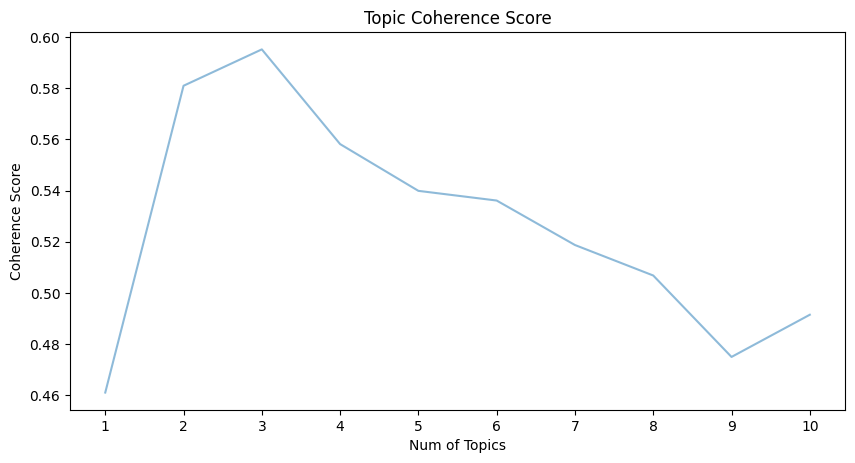

In [33]:
# METHOD FOR TESTING COHERENCE SCORE FOR DIFFERING NUMBERS OF TOPICS

from gensim.models import CoherenceModel

topic_coherence = []
num_topics = 10

for n in trange(1, num_topics + 1):
    
    lda_model = build_lda(n)
    
    # Compute Perplexity
    topic_perplexity = lda_model.log_perplexity(corpus)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    topic_coherence.append(coherence_model_lda.get_coherence())


x = [i for i in range(1, num_topics + 1)]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Topic Coherence Score')
ax1.set_xlabel('Num of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_xticks(x)
ax1.plot(x, topic_coherence, alpha=0.5)

In [45]:
three_topics_lda = build_lda(3)
three_topics_lda.print_topics()

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.034*"work" + 0.031*"school" + 0.020*"home" + 0.016*"tier" + 0.013*"mask" + 0.011*"open" + 0.011*"kid" + 0.011*"close" + 0.010*"child" + 0.010*"go"'),
 (1,
  '0.026*"people" + 0.019*"get" + 0.017*"do" + 0.014*"go" + 0.012*"think" + 0.011*"say" + 0.010*"make" + 0.009*"know" + 0.009*"see" + 0.008*"s"'),
 (2,
  '0.024*"covid" + 0.022*"vaccine" + 0.018*"case" + 0.015*"test" + 0.014*"day" + 0.013*"number" + 0.013*"dose" + 0.012*"death" + 0.010*"https" + 0.010*"hospital"')]

In [36]:
four_topics_lda = build_lda(4)
four_topics_lda.print_topics()

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
five_topics_lda = build_lda(5)
five_topics_lda.print_topics()

In [39]:
six_topics_lda = build_lda(6)
six_topics_lda.print_topics()

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.038*"want" + 0.028*"mask" + 0.025*"open" + 0.025*"kid" + 0.022*"family" + 0.019*"change" + 0.018*"able" + 0.018*"friend" + 0.017*"wear" + 0.017*"issue"'),
 (1,
  '0.028*"say" + 0.028*"day" + 0.024*"make" + 0.022*"see" + 0.020*"week" + 0.019*"m" + 0.019*"year" + 0.017*"really" + 0.017*"thing" + 0.016*"good"'),
 (2,
  '0.043*"covid" + 0.024*"number" + 0.022*"death" + 0.017*"hospital" + 0.014*"high" + 0.014*"close" + 0.011*"care" + 0.011*"likely" + 0.010*"health" + 0.010*"comment"'),
 (3,
  '0.057*"school" + 0.039*"test" + 0.037*"be" + 0.032*"re" + 0.031*"first" + 0.022*"hope" + 0.019*"child" + 0.015*"reason" + 0.015*"pandemic" + 0.014*"problem"'),
 (4,
  '0.045*"get" + 0.040*"go" + 0.040*"do" + 0.027*"think" + 0.023*"work" + 0.022*"time" + 0.021*"know" + 0.019*"s" + 0.019*"well" + 0.017*"need"'),
 (5,
  '0.079*"people" + 0.028*"vaccine" + 0.023*"case" + 0.021*"lockdown" + 0.020*"government" + 0.016*"dose" + 0.015*"bad" + 0.015*"many" + 0.014*"new" + 0.013*"point"')]

In [42]:
seven_topics_lda = build_lda(7)
seven_topics_lda.print_topics()

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.063*"go" + 0.037*"work" + 0.034*"time" + 0.030*"week" + 0.024*"still" + 0.021*"home" + 0.021*"back" + 0.021*"ni" + 0.021*"tier" + 0.020*"come"'),
 (1,
  '0.060*"need" + 0.041*"death" + 0.038*"month" + 0.026*"restriction" + 0.025*"thank" + 0.023*"rate" + 0.021*"use" + 0.019*"nhs" + 0.019*"issue" + 0.016*"result"'),
 (2,
  '0.048*"school" + 0.031*"also" + 0.029*"number" + 0.022*"risk" + 0.018*"high" + 0.017*"close" + 0.014*"care" + 0.014*"stay" + 0.013*"reason" + 0.012*"post"'),
 (3,
  '0.053*"government" + 0.024*"child" + 0.019*"pandemic" + 0.018*"follow" + 0.017*"march" + 0.016*"different" + 0.015*"job" + 0.015*"travel" + 0.014*"break" + 0.014*"possible"'),
 (4,
  '0.052*"day" + 0.048*"covid" + 0.035*"case" + 0.029*"test" + 0.026*"dose" + 0.025*"long" + 0.021*"new" + 0.020*"https" + 0.019*"hospital" + 0.019*"rule"'),
 (5,
  '0.095*"people" + 0.034*"vaccine" + 0.027*"year" + 0.025*"lockdown" + 0.024*"take" + 0.021*"give" + 0.018*"bad" + 0.017*"first" + 0.016*"point" + 0.016*"m

In [46]:
# Visualize LDA

import pyLDAvis.gensim_models
import os
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(three_topics_lda,
                                     corpus,
                                     id2word)
vis

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.149949  0.278705       1        1  59.525527
2     -0.187994 -0.258544       2        1  22.725458
0      0.337943 -0.020161       3        1  17.749015, topic_info=        Term           Freq          Total Category  logprob  loglift
368     work   58377.000000   58377.000000  Default  30.0000  30.0000
558   school   53247.000000   53247.000000  Default  29.0000  29.0000
915    covid   54078.000000   54078.000000  Default  28.0000  28.0000
6     people  153007.000000  153007.000000  Default  27.0000  27.0000
970  vaccine   49650.000000   49650.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
11        go   17071.506848   99924.943231   Topic3  -4.6155  -0.0382
544    leave    8376.317757   13610.698200   Topic3  -5.3276   1.2434
79       day   12004.606340   61236.972581   Topic3  -4.9677   0.0994
455   family    8129.908125   16730.778716   Topic3  -5.3574   1.0071
263     keep    7641.383824   23960.200576   Topic3  -5.4194   0.5860

[159 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
348       1  0.999964  actually
389       1  0.103267     allow
389       2  0.005617     allow
389       3  0.891045     allow
134       1  0.473499      also
...     ...       ...       ...
54        1  0.999988      well
368       3  0.999987      work
1023      3  0.999864    worker
297       1  0.997682      year
297       2  0.002309      year

[172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [49]:
pyLDAvis.save_html(vis, '3_topic_lda_model.html')

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
